In [2]:
import json
from collections import defaultdict, Counter
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
import scipy.stats as stats
import gzip
import scipy.sparse as sparse
import statsmodels.api as sm
import random
from sklearn.metrics import precision_recall_curve

//anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
//anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [139]:
#ped_file = '../../DATA/ssc.hg38/ssc.ped'
#phase_dir = '../phased_ssc.hg38_del'
#assembly = '38'

#ped_file = '../../DATA/ihart.ms2/ihart.ped'
#phase_dir = '../phased_ihart.ms2_del'
#assembly = '38'

#ped_file = '../../DATA/ihart.chip/ihart.ped'
#phase_dir = '../phased_ihart.chip_del'
#assembly = '19'

#ped_file = '../../DATA/ihart.v34/ihart.ped'
#phase_dir = '../phased_ihart.v34_del'
#assembly = '19'

ped_file = '../../DATA/spark/spark.ped'
phase_dir = '../phased_spark_del'
assembly = '38'

In [140]:
# pull affected status
# (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()
fam_to_inds = dict()
in_ped = set()
with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if len(pieces) >= 6:
            fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
            #if child_id in ssc_old_id_to_new_id and m_id in ssc_old_id_to_new_id and f_id in ssc_old_id_to_new_id:
                #child_id = ssc_old_id_to_new_id[child_id]
                #f_id = ssc_old_id_to_new_id[f_id]
                #m_id = ssc_old_id_to_new_id[m_id]
            child_id_to_affected[child_id] = disease_status
            child_id_to_sex[child_id] = sex

            if f_id != '0' and m_id != '0':
                if (fam_id, m_id, f_id) not in fam_to_inds:
                    fam_to_inds[(fam_id, m_id, f_id)] = [m_id, f_id]
                fam_to_inds[(fam_id, m_id, f_id)].append(child_id)
            in_ped.add(m_id)
            in_ped.add(f_id)
            in_ped.add(child_id)
                
print('ped loaded')
print('children', len(child_id_to_affected))

ped loaded
children 81355


In [141]:
with open('%s/deletions.json' % phase_dir) as f:
    deletions = json.load(f)

In [167]:
# filter deletions
deletions = [d for d in deletions if d['length']>=100]
print('remaining deletions', len(deletions))

deletions = [d for d in deletions if d['is_inherited']]
print('remaining deletions', len(deletions))

# pull cytobands
intervals = []

with open('../data/cytoBand%s.txt' % assembly, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[0][3:] in chroms:
            intervals.append((pieces[0][3:], pieces[3], int(pieces[1]), int(pieces[2]), pieces[4]))
intervals = sorted(intervals, key=lambda x: (int(x[0]), x[2]))

interval_chroms = np.array([int(x[0]) for x in intervals])
first_chrom = [0] + np.where(interval_chroms[1:] != interval_chroms[:-1])[0].tolist()

# filter deletions that go through the centromere
centromeres = [x for x in intervals if x[-1] == 'acen']
centromere_deletions = set()
for i, d in enumerate(deletions):
    for chrom, _, start_pos, end_pos, _ in centromeres:
        if d['chrom'] == chrom:
            if d['start_pos'] >= start_pos and d['start_pos'] <= end_pos:
                centromere_deletions.add(i)
            elif d['end_pos'] >= start_pos and d['end_pos'] <= end_pos:
                centromere_deletions.add(i)
            elif d['start_pos'] <= start_pos and d['end_pos'] >= end_pos:
                centromere_deletions.add(i)
print('centromere deletions', len(centromere_deletions)) 

deletions = [d for i, d in enumerate(deletions) if i not in centromere_deletions]


remaining deletions 3218
remaining deletions 3218
centromere deletions 3


In [168]:
deletions = []
notrans_deletions = []
fam_to_num_bases = defaultdict(int)
fam_to_num_dels = defaultdict(int)
fam_to_size = dict([(x[0], len(v)) for x, v in fam_to_inds.items()])

for d in full_deletions:
    if d['is_inherited'] and d['family_size']>=4 and fam_to_size[d['family']] == d['family_size']:
        for child in d['trans']:
            deletions.append({
                                'family': d['family'],
                                'child': child,
                                'chrom': d['chrom'],
                                'start_pos': d['start_pos'],
                                'end_pos': d['end_pos'],
                                'length': d['length'],
                                'opt_start_pos': d['opt_start_pos'],
                                'opt_end_pos': d['opt_end_pos'],
                                'is_mat': d['is_mat'],
                                'is_pat': d['is_pat'],
                                'mother': d['mother'],
                                'father': d['father'],
                                'is_inherited': d['is_inherited'],
                                'is_denovo': d['is_denovo']
                        })
        for child in d['notrans']:
            notrans_deletions.append({
                                'family': d['family'],
                                'child': child,
                                'chrom': d['chrom'],
                                'start_pos': d['start_pos'],
                                'end_pos': d['end_pos'],
                                'length': d['length'],
                                'opt_start_pos': d['opt_start_pos'],
                                'opt_end_pos': d['opt_end_pos'],
                                'is_mat': d['is_mat'],
                                'is_pat': d['is_pat'],
                                'mother': d['mother'],
                                'father': d['father'],
                                'is_inherited': d['is_inherited'],
                                'is_denovo': d['is_denovo']
                        })
        assert fam_to_size[d['family']] == d['family_size']
                
        fam_to_num_bases[d['family']] += d['length']
        fam_to_num_dels[d['family']] += 1

In [144]:
with open('%s/families.json' % phase_dir) as f:
    families = set(json.load(f))

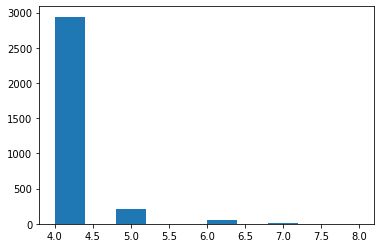

In [145]:
plt.hist([fam_to_size[x] for x in families])
plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


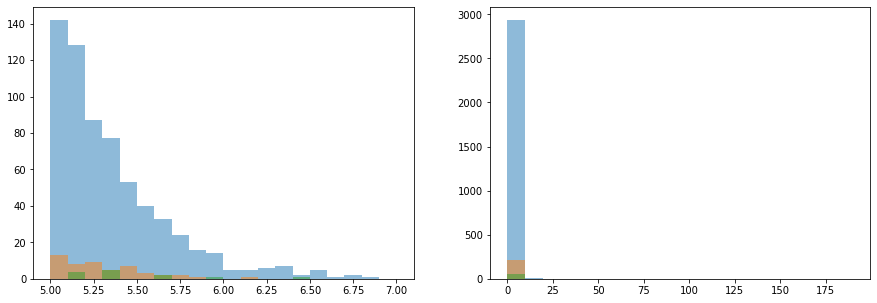

In [146]:
plt.figure(figsize=(15, 5))
for i in range(4, 7):
    plt.subplot(1, 2, 1)
    plt.hist([np.clip(np.log10(fam_to_num_bases[x]), 4, 8) for x in families if fam_to_size[x]==i], alpha=0.5, bins=np.arange(5, 7.1, 0.1))
    plt.subplot(1, 2, 2)
    plt.hist([np.clip(fam_to_num_dels[x], 0, 200) for x in families if fam_to_size[x]==i], alpha=0.5, bins=np.arange(0, 200, 10))
plt.show()

In [147]:
with open('%s/individuals.json' % phase_dir) as f:
    individuals = set(json.load(f))
    
with open('%s/families.json' % phase_dir) as f:
    families = set(json.load(f))
    
children = set()
for fam, inds in fam_to_inds.items():
    #print(fam, inds)
    if fam[0] in families and len(inds)>3:
        children.update([x for x in inds[2:] if x in individuals])
    
assert np.all(x in in_ped for x in individuals)
child_to_index = dict([(x, i) for i, x in enumerate(children)])

print(len(individuals), len(children))

13175 6721


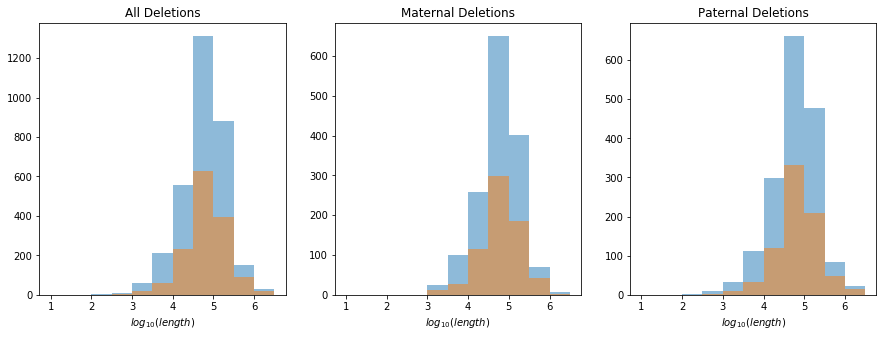

In [148]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
del_n, _, _ = plt.hist([np.log10(d['length']) for d in deletions], bins=np.arange(1, 7, 0.5), alpha=0.5)
nodel_n, _, _ = plt.hist([np.log10(d['length']) for d in notrans_deletions], bins=np.arange(1, 7, 0.5), alpha=0.5)
plt.title('All Deletions')
plt.xlabel('$log_{10}(length)$')

plt.subplot(1, 3, 2)
del_n, _, _ = plt.hist([np.log10(d['length']) for d in deletions if d['is_mat']], bins=np.arange(1, 7, 0.5), alpha=0.5)
nodel_n, _, _ = plt.hist([np.log10(d['length']) for d in notrans_deletions if d['is_mat']], bins=np.arange(1, 7, 0.5), alpha=0.5)
plt.title('Maternal Deletions')
plt.xlabel('$log_{10}(length)$')

plt.subplot(1, 3, 3)
del_n, _, _ = plt.hist([np.log10(d['length']) for d in deletions if d['is_pat']], bins=np.arange(1, 7, 0.5), alpha=0.5)
nodel_n, _, _ = plt.hist([np.log10(d['length']) for d in notrans_deletions if d['is_pat']], bins=np.arange(1, 7, 0.5), alpha=0.5)
plt.title('Paternal Deletions')
plt.xlabel('$log_{10}(length)$')

plt.show()

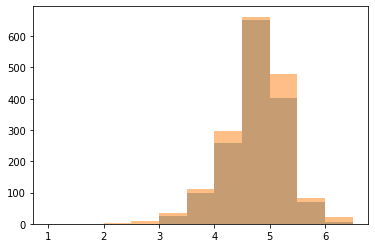

In [149]:
plt.hist([np.log10(d['length']) for d in deletions if d['is_mat']], bins=np.arange(1, 7, 0.5), alpha=0.5)
plt.hist([np.log10(d['length']) for d in deletions if d['is_pat']], bins=np.arange(1, 7, 0.5), alpha=0.5)
plt.show()

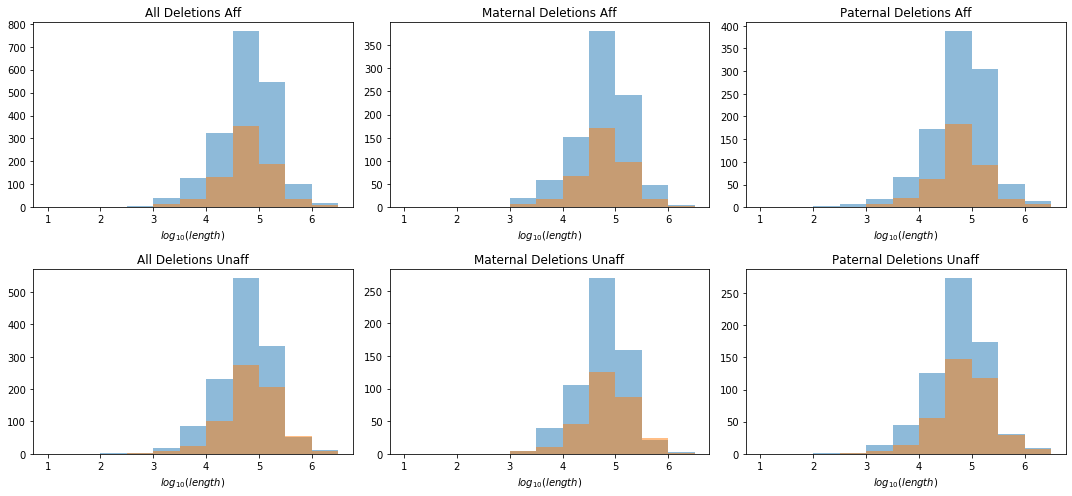

In [150]:
plt.figure(figsize=(15, 7))
plt.subplot(2, 3, 1)
aff_del_n, _, _ = plt.hist([np.log10(d['length']) for d in deletions if child_id_to_affected[d['child']]=='2'], bins=np.arange(1, 7, 0.5), alpha=0.5)
aff_nodel_n, _, _ = plt.hist([np.log10(d['length']) for d in notrans_deletions if child_id_to_affected[d['child']]=='2'], bins=np.arange(1, 7, 0.5), alpha=0.5)
plt.title('All Deletions Aff')
plt.xlabel('$log_{10}(length)$')

plt.subplot(2, 3, 2)
mat_aff_del_n, _, _ = plt.hist([np.log10(d['length']) for d in deletions if child_id_to_affected[d['child']]=='2' and d['is_mat']], bins=np.arange(1, 7, 0.5), alpha=0.5)
mat_aff_nodel_n, _, _ = plt.hist([np.log10(d['length']) for d in notrans_deletions if child_id_to_affected[d['child']]=='2' and d['is_mat']], bins=np.arange(1, 7, 0.5), alpha=0.5)
plt.title('Maternal Deletions Aff')
plt.xlabel('$log_{10}(length)$')

plt.subplot(2, 3, 3)
pat_aff_del_n, _, _ = plt.hist([np.log10(d['length']) for d in deletions if child_id_to_affected[d['child']]=='2' and d['is_pat']], bins=np.arange(1, 7, 0.5), alpha=0.5)
pat_aff_nodel_n, _, _ = plt.hist([np.log10(d['length']) for d in notrans_deletions if child_id_to_affected[d['child']]=='2' and d['is_pat']], bins=np.arange(1, 7, 0.5), alpha=0.5)
plt.title('Paternal Deletions Aff')
plt.xlabel('$log_{10}(length)$')

plt.subplot(2, 3, 4)
unaff_del_n, _, _ = plt.hist([np.log10(d['length']) for d in deletions if child_id_to_affected[d['child']]=='1'], bins=np.arange(1, 7, 0.5), alpha=0.5)
unaff_nodel_n, _, _ = plt.hist([np.log10(d['length']) for d in notrans_deletions if child_id_to_affected[d['child']]=='1'], bins=np.arange(1, 7, 0.5), alpha=0.5)
plt.title('All Deletions Unaff')
plt.xlabel('$log_{10}(length)$')

plt.subplot(2, 3, 5)
mat_unaff_del_n, _, _ = plt.hist([np.log10(d['length']) for d in deletions if child_id_to_affected[d['child']]=='1' and d['is_mat']], bins=np.arange(1, 7, 0.5), alpha=0.5)
mat_unaff_nodel_n, _, _ = plt.hist([np.log10(d['length']) for d in notrans_deletions if child_id_to_affected[d['child']]=='1' and d['is_mat']], bins=np.arange(1, 7, 0.5), alpha=0.5)
plt.title('Maternal Deletions Unaff')
plt.xlabel('$log_{10}(length)$')

plt.subplot(2, 3, 6)
pat_unaff_del_n, _, _ = plt.hist([np.log10(d['length']) for d in deletions if child_id_to_affected[d['child']]=='1' and d['is_pat']], bins=np.arange(1, 7, 0.5), alpha=0.5)
pat_unaff_nodel_n, _, _ = plt.hist([np.log10(d['length']) for d in notrans_deletions if child_id_to_affected[d['child']]=='1' and d['is_pat']], bins=np.arange(1, 7, 0.5), alpha=0.5)
plt.title('Paternal Deletions Unaff')
plt.xlabel('$log_{10}(length)$')

plt.tight_layout()
plt.show()

In [151]:
print(len(deletions), 
      len([x for x in deletions if x['is_mat']]),
     len([x for x in deletions if x['is_pat']]))

3218 1509 1709


In [152]:
num_deletions = np.zeros((len(children),))
num_notrans_deletions = np.zeros((len(children),))
mat_num_deletions = np.zeros((len(children),))
mat_num_notrans_deletions = np.zeros((len(children),))
pat_num_deletions = np.zeros((len(children),))
pat_num_notrans_deletions = np.zeros((len(children),))

num_bases = np.zeros((len(children),))
num_notrans_bases = np.zeros((len(children),))
mat_num_bases =np.zeros((len(children),))
mat_num_notrans_bases = np.zeros((len(children),))
pat_num_bases = np.zeros((len(children),))
pat_num_notrans_bases = np.zeros((len(children),))

for d in deletions:
    child_index = child_to_index[d['child']]
    num_deletions[child_index] += 1
    num_bases[child_index] += d['length']
    if d['is_mat']:
        mat_num_deletions[child_index] += 1
        mat_num_bases[child_index] += d['length']
    if d['is_pat']:
        pat_num_deletions[child_index] += 1
        pat_num_bases[child_index] += d['length']
    
for d in notrans_deletions:
    child_index = child_to_index[d['child']]
    num_notrans_deletions[child_index] += 1
    num_notrans_bases[child_index] += d['length']
    if d['is_mat']:
        mat_num_notrans_deletions[child_index] += 1
        mat_num_notrans_bases[child_index] += d['length']
    if d['is_pat']:
        pat_num_notrans_deletions[child_index] += 1
        pat_num_notrans_bases[child_index] += d['length']

In [153]:
is_aut = np.array([child_id_to_affected[x]=='2' for x in children])
is_nt = np.array([child_id_to_affected[x]=='1' for x in children])

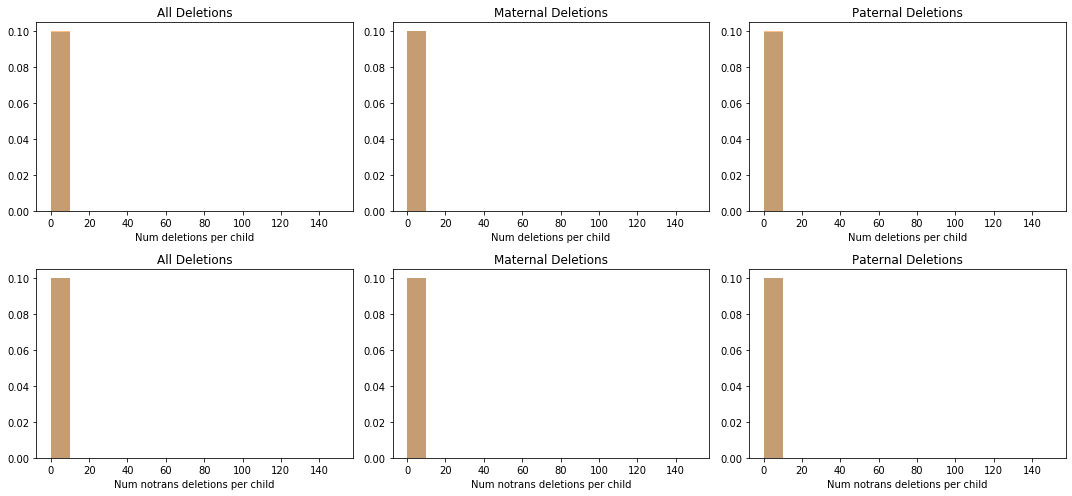

In [154]:
plt.figure(figsize=(15, 7))

bins = np.arange(0, 160, 10)
max_clip = 150

plt.subplot(2, 3, 1)
plt.hist(np.clip(num_deletions[is_aut], 0, max_clip), alpha=0.5, bins=bins, density=True)
plt.hist(np.clip(num_deletions[is_nt], 0, max_clip), alpha=0.5, bins=bins, density=True)
plt.title('All Deletions')
plt.xlabel('Num deletions per child')

plt.subplot(2, 3, 2)
plt.hist(np.clip(mat_num_deletions[is_aut], 0, max_clip), alpha=0.5, bins=bins, density=True)
plt.hist(np.clip(mat_num_deletions[is_nt], 0, max_clip), alpha=0.5, bins=bins, density=True)
plt.title('Maternal Deletions')
plt.xlabel('Num deletions per child')

plt.subplot(2, 3, 3)
plt.hist(np.clip(pat_num_deletions[is_aut], 0, max_clip), alpha=0.5, bins=bins, density=True)
plt.hist(np.clip(pat_num_deletions[is_nt], 0, max_clip), alpha=0.5, bins=bins, density=True)
plt.title('Paternal Deletions')
plt.xlabel('Num deletions per child')

plt.subplot(2, 3, 4)
plt.hist(np.clip(num_notrans_deletions[is_aut], 0, max_clip), alpha=0.5, bins=bins, density=True)
plt.hist(np.clip(num_notrans_deletions[is_nt], 0, max_clip), alpha=0.5, bins=bins, density=True)
plt.title('All Deletions')
plt.xlabel('Num notrans deletions per child')

plt.subplot(2, 3, 5)
plt.hist(np.clip(mat_num_notrans_deletions[is_aut], 0, max_clip), alpha=0.5, bins=bins, density=True)
plt.hist(np.clip(mat_num_notrans_deletions[is_nt], 0, max_clip), alpha=0.5, bins=bins, density=True)
plt.title('Maternal Deletions')
plt.xlabel('Num notrans deletions per child')

plt.subplot(2, 3, 6)
plt.hist(np.clip(pat_num_notrans_deletions[is_aut], 0, max_clip), alpha=0.5, bins=bins, density=True)
plt.hist(np.clip(pat_num_notrans_deletions[is_nt], 0, max_clip), alpha=0.5, bins=bins, density=True)
plt.title('Paternal Deletions')
plt.xlabel('Num notrans deletions per child')


plt.tight_layout()
plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0, 'Num bases deleted per child')

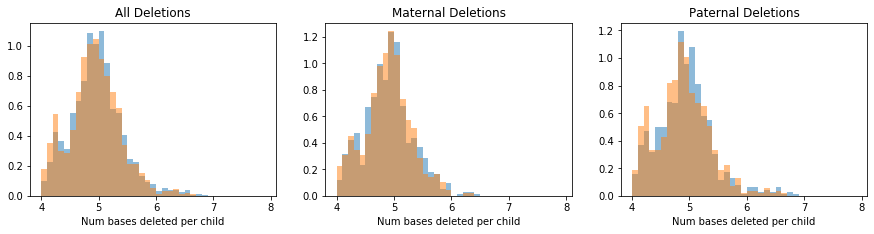

In [155]:
plt.figure(figsize=(15, 7))

bins = np.arange(4, 8, 0.1)

plt.subplot(2, 3, 1)
plt.hist(np.clip(np.log10(num_bases[is_aut]), -1, None), alpha=0.5, bins=bins, density=True)
plt.hist(np.clip(np.log10(num_bases[is_nt]), -1, None), alpha=0.5, bins=bins, density=True)
plt.title('All Deletions')
plt.xlabel('Num bases deleted per child')

plt.subplot(2, 3, 2)
plt.hist(np.clip(np.log10(mat_num_bases[is_aut]), -1, None), alpha=0.5, bins=bins, density=True)
plt.hist(np.clip(np.log10(mat_num_bases[is_nt]), -1, None), alpha=0.5, bins=bins, density=True)
plt.title('Maternal Deletions')
plt.xlabel('Num bases deleted per child')

plt.subplot(2, 3, 3)
plt.hist(np.clip(np.log10(pat_num_bases[is_aut]), -1, None), alpha=0.5, bins=bins, density=True)
plt.hist(np.clip(np.log10(pat_num_bases[is_nt]), -1, None), alpha=0.5, bins=bins, density=True)
plt.title('Paternal Deletions')
plt.xlabel('Num bases deleted per child')


In [156]:
print(np.sum(is_aut), np.sum(is_nt))

3861 2860


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:33: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:40: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:41: RuntimeWarning: divide by zero encountered in log10


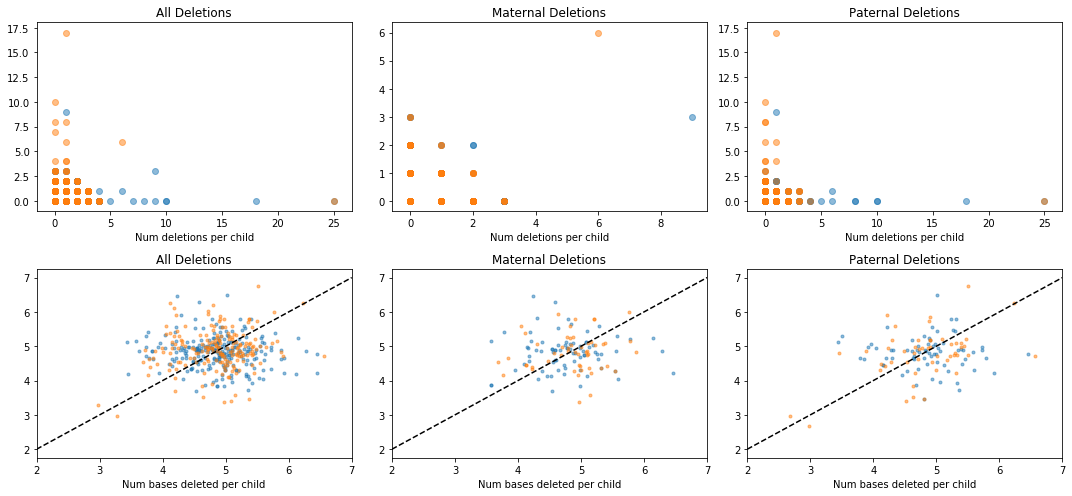

In [157]:
plt.figure(figsize=(15, 7))

plt.subplot(2, 3, 1)
plt.scatter(num_deletions[is_aut], num_notrans_deletions[is_aut], alpha=0.5)
plt.scatter(num_deletions[is_nt], num_notrans_deletions[is_nt], alpha=0.5)
plt.title('All Deletions')
plt.xlabel('Num deletions per child')

plt.subplot(2, 3, 2)
plt.scatter(mat_num_deletions[is_aut], mat_num_notrans_deletions[is_aut], alpha=0.5)
plt.scatter(mat_num_deletions[is_nt], mat_num_notrans_deletions[is_nt], alpha=0.5)
plt.title('Maternal Deletions')
plt.xlabel('Num deletions per child')

plt.subplot(2, 3, 3)
plt.scatter(pat_num_deletions[is_aut], pat_num_notrans_deletions[is_aut], alpha=0.5)
plt.scatter(pat_num_deletions[is_nt], pat_num_notrans_deletions[is_nt], alpha=0.5)
plt.title('Paternal Deletions')
plt.xlabel('Num deletions per child')

bins = np.arange(0, 8, 0.1)

plt.subplot(2, 3, 4)
plt.scatter(np.log10(num_bases[is_aut]), np.log10(num_notrans_bases[is_aut]), alpha=0.5, marker='.')
plt.scatter(np.log10(num_bases[is_nt]), np.log10(num_notrans_bases[is_nt]), alpha=0.5, marker='.')
plt.title('All Deletions')
plt.xlabel('Num bases deleted per child')
plt.xlim([2, 7])
plt.plot([2, 7], [2, 7], color='black', linestyle='--')

plt.subplot(2, 3, 5)
plt.scatter(np.log10(mat_num_bases[is_aut]), np.log10(mat_num_notrans_bases[is_aut]), alpha=0.5, marker='.')
plt.scatter(np.log10(mat_num_bases[is_nt]), np.log10(mat_num_notrans_bases[is_nt]), alpha=0.5, marker='.')
plt.title('Maternal Deletions')
plt.xlabel('Num bases deleted per child')
plt.xlim([2, 7])
plt.plot([2, 7], [2, 7], color='black', linestyle='--')

plt.subplot(2, 3, 6)
plt.scatter(np.log10(pat_num_bases[is_aut]), np.log10(pat_num_notrans_bases[is_aut]), alpha=0.5, marker='.')
plt.scatter(np.log10(pat_num_bases[is_nt]), np.log10(pat_num_notrans_bases[is_nt]), alpha=0.5, marker='.')
plt.title('Paternal Deletions')
plt.xlabel('Num bases deleted per child')
plt.xlim([2, 7])
plt.plot([2, 7], [2, 7], color='black', linestyle='--')

plt.tight_layout()
plt.show()

In [158]:
print(np.sum(num_bases[is_aut]>num_notrans_bases[is_aut])/np.sum(is_aut), 
      np.sum(num_bases[is_nt]>num_notrans_bases[is_nt])/np.sum(is_nt))
print(stats.chi2_contingency([[np.sum(num_bases[is_aut]>num_notrans_bases[is_aut]), 
                               np.sum(num_bases[is_nt]>num_notrans_bases[is_nt])],
                              [np.sum(num_bases[is_aut]<num_notrans_bases[is_aut]), 
                               np.sum(num_bases[is_nt]<num_notrans_bases[is_nt])],
                             ]))


print(np.sum(mat_num_bases[is_aut]>mat_num_notrans_bases[is_aut])/np.sum(is_aut), 
      np.sum(mat_num_bases[is_nt]>mat_num_notrans_bases[is_nt])/np.sum(is_nt),
      np.sum(pat_num_bases[is_aut]>pat_num_notrans_bases[is_aut])/np.sum(is_aut), 
      np.sum(pat_num_bases[is_nt]>pat_num_notrans_bases[is_nt])/np.sum(is_nt))
print(stats.chi2_contingency([[[np.sum(mat_num_bases[is_aut]>mat_num_notrans_bases[is_aut]), 
                               np.sum(mat_num_bases[is_nt]>mat_num_notrans_bases[is_nt])],
                              [np.sum(mat_num_bases[is_aut]<mat_num_notrans_bases[is_aut]), 
                               np.sum(mat_num_bases[is_nt]<mat_num_notrans_bases[is_nt])],
                             ],
                              [[np.sum(pat_num_bases[is_aut]>pat_num_notrans_bases[is_aut]), 
                               np.sum(pat_num_bases[is_nt]>pat_num_notrans_bases[is_nt])],
                              [np.sum(pat_num_bases[is_aut]<pat_num_notrans_bases[is_aut]), 
                               np.sum(pat_num_bases[is_nt]<pat_num_notrans_bases[is_nt])],
                             ]]))



0.3423983423983424 0.31643356643356646
(5.983047788540588, 0.01444402075340075, 1, array([[1289.67799753,  937.32200247],
       [ 584.32200247,  424.67799753]]))
0.19476819476819476 0.17587412587412588 0.20512820512820512 0.19475524475524475
(6.535149227900847, 0.1625891269245465, 4, array([[[730.12144685, 529.05414996],
        [326.92842052, 236.89598266]],

       [[779.78412344, 565.04027975],
        [349.16600919, 253.00958763]]]))


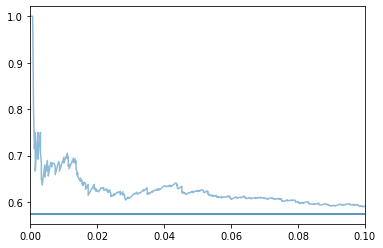

In [159]:
precision, recall, _ = precision_recall_curve(is_aut, num_bases)
plt.plot(recall, precision, alpha=0.5)
#precision, recall, _ = precision_recall_curve(is_aut, num_bases-num_notrans_bases)
#plt.plot(recall, precision, alpha=0.5)
plt.axhline(np.sum(is_aut)/len(children))
plt.xlim([0, 0.1])
plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in log10


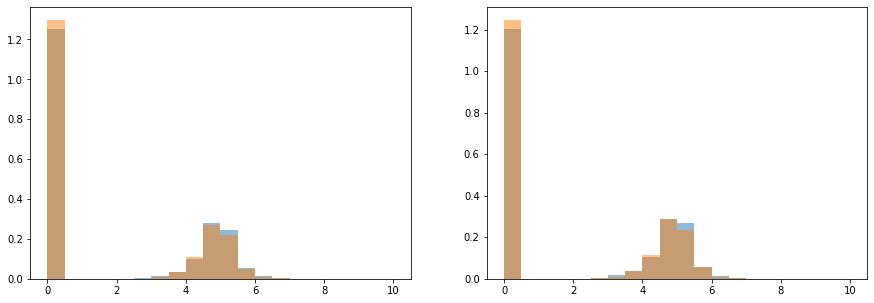

In [160]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(np.clip(np.log10(num_bases[is_aut]), 0, 10), alpha=0.5, bins=np.arange(0, 10.5, 0.5), density=True)
plt.hist(np.clip(np.log10(num_bases[is_nt]), 0, 10), alpha=0.5, bins=np.arange(0, 10.5, 0.5), density=True)

plt.subplot(1, 2, 2)
plt.hist(np.clip(np.log10((num_bases-num_notrans_bases)[is_aut]), 0, 10), alpha=0.5, bins=np.arange(0, 10.5, 0.5), density=True)
plt.hist(np.clip(np.log10((num_bases-num_notrans_bases)[is_nt]), 0, 10), alpha=0.5, bins=np.arange(0, 10.5, 0.5), density=True)

plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


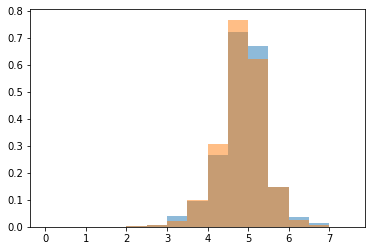

In [161]:
plt.hist(np.log10(num_bases[is_aut]-num_notrans_bases[is_aut]), alpha=0.5, bins=np.arange(0, 8, 0.5), density=True)
plt.hist(np.log10(num_bases[is_nt]-num_notrans_bases[is_nt]), alpha=0.5, bins=np.arange(0, 8, 0.5), density=True)

plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:36: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:41: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/py

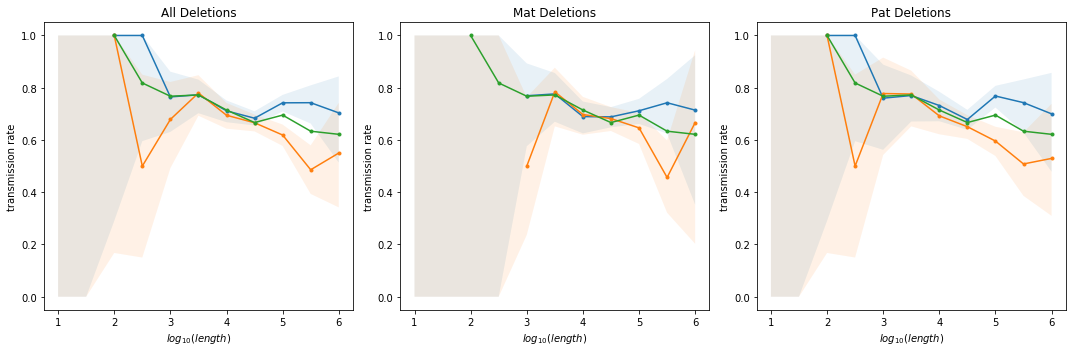

In [162]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(np.arange(1, 6.5, 0.5), aff_del_n/(aff_del_n+aff_nodel_n), marker='.')
plt.fill_between(np.arange(1, 6.5, 0.5),
                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[0] for x, y in zip(aff_del_n, aff_nodel_n)],
                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[1] for x, y in zip(aff_del_n, aff_nodel_n)],
                alpha=0.1)
plt.plot(np.arange(1, 6.5, 0.5), unaff_del_n/(unaff_del_n+unaff_nodel_n), marker='.')
plt.fill_between(np.arange(1, 6.5, 0.5),
                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[0] for x, y in zip(unaff_del_n, unaff_nodel_n)],
                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[1] for x, y in zip(unaff_del_n, unaff_nodel_n)],
                alpha=0.1)
plt.plot(np.arange(1, 6.5, 0.5), del_n/(del_n+nodel_n), marker='.')
plt.title('All Deletions')
plt.xlabel('$log_{10}(length)$')
plt.ylabel('transmission rate')

plt.subplot(1, 3, 2)
plt.plot(np.arange(1, 6.5, 0.5), mat_aff_del_n/(mat_aff_del_n+mat_aff_nodel_n), marker='.')
plt.fill_between(np.arange(1, 6.5, 0.5),
                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[0] for x, y in zip(mat_aff_del_n, mat_aff_nodel_n)],
                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[1] for x, y in zip(mat_aff_del_n, mat_aff_nodel_n)],
                alpha=0.1)
plt.plot(np.arange(1, 6.5, 0.5), mat_unaff_del_n/(mat_unaff_del_n+mat_unaff_nodel_n), marker='.')
plt.fill_between(np.arange(1, 6.5, 0.5),
                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[0] for x, y in zip(mat_unaff_del_n, mat_unaff_nodel_n)],
                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[1] for x, y in zip(mat_unaff_del_n, mat_unaff_nodel_n)],
                alpha=0.1)
plt.plot(np.arange(1, 6.5, 0.5), del_n/(del_n+nodel_n), marker='.')
plt.title('Mat Deletions')
plt.xlabel('$log_{10}(length)$')
plt.ylabel('transmission rate')

plt.subplot(1, 3, 3)
plt.plot(np.arange(1, 6.5, 0.5), pat_aff_del_n/(pat_aff_del_n+pat_aff_nodel_n), marker='.')
plt.fill_between(np.arange(1, 6.5, 0.5),
                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[0] for x, y in zip(pat_aff_del_n, pat_aff_nodel_n)],
                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[1] for x, y in zip(pat_aff_del_n, pat_aff_nodel_n)],
                alpha=0.1)
plt.plot(np.arange(1, 6.5, 0.5), pat_unaff_del_n/(pat_unaff_del_n+pat_unaff_nodel_n), marker='.')
plt.fill_between(np.arange(1, 6.5, 0.5),
                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[0] for x, y in zip(pat_unaff_del_n, pat_unaff_nodel_n)],
                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[1] for x, y in zip(pat_unaff_del_n, pat_unaff_nodel_n)],
                alpha=0.1)
plt.plot(np.arange(1, 6.5, 0.5), del_n/(del_n+nodel_n), marker='.')
plt.title('Pat Deletions')
plt.xlabel('$log_{10}(length)$')
plt.ylabel('transmission rate')

plt.tight_layout()
plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:39: RuntimeWarning: invalid value encountered in true_divide


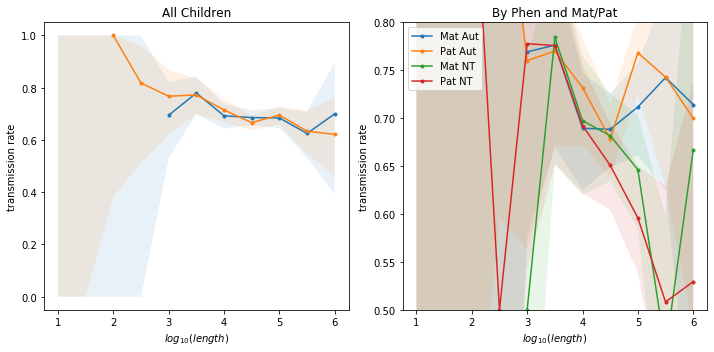

In [163]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(np.arange(1, 6.5, 0.5), (mat_aff_del_n+mat_unaff_del_n)/(mat_aff_del_n+mat_aff_nodel_n+mat_unaff_del_n+mat_unaff_nodel_n), marker='.')
plt.fill_between(np.arange(1, 6.5, 0.5),
                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[0] for x, y in zip(mat_aff_del_n+mat_unaff_del_n, mat_aff_nodel_n+mat_unaff_nodel_n)],
                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[1] for x, y in zip(mat_aff_del_n+mat_unaff_del_n, mat_aff_nodel_n+mat_unaff_nodel_n)],
                alpha=0.1)
plt.plot(np.arange(1, 6.5, 0.5), (pat_aff_del_n+pat_unaff_del_n)/(pat_aff_del_n+pat_aff_nodel_n+pat_unaff_del_n+pat_unaff_nodel_n), marker='.')
plt.fill_between(np.arange(1, 6.5, 0.5),
                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[0] for x, y in zip(pat_aff_del_n+pat_unaff_del_n, pat_aff_nodel_n+pat_unaff_nodel_n)],
                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[1] for x, y in zip(pat_aff_del_n+pat_unaff_del_n, pat_aff_nodel_n+pat_unaff_nodel_n)],
                alpha=0.1)
plt.title('All Children')
plt.xlabel('$log_{10}(length)$')
plt.ylabel('transmission rate')

plt.subplot(1, 3, 2)
plt.plot(np.arange(1, 6.5, 0.5), (mat_aff_del_n)/(mat_aff_del_n+mat_aff_nodel_n), marker='.', label='Mat Aut')
plt.fill_between(np.arange(1, 6.5, 0.5),
                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[0] for x, y in zip(mat_aff_del_n, mat_aff_nodel_n)],
                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[1] for x, y in zip(mat_aff_del_n, mat_aff_nodel_n)],
                alpha=0.1)
plt.plot(np.arange(1, 6.5, 0.5), (pat_aff_del_n)/(pat_aff_del_n+pat_aff_nodel_n), marker='.', label='Pat Aut')
plt.fill_between(np.arange(1, 6.5, 0.5),
                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[0] for x, y in zip(pat_aff_del_n, pat_aff_nodel_n)],
                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[1] for x, y in zip(pat_aff_del_n, pat_aff_nodel_n)],
                alpha=0.1)
#plt.title('Aff Children')
#plt.xlabel('$log_{10}(length)$')
#plt.ylabel('transmission rate')
#
#plt.subplot(1, 3, 3)
plt.plot(np.arange(1, 6.5, 0.5), (mat_unaff_del_n)/(mat_unaff_del_n+mat_unaff_nodel_n), marker='.', label='Mat NT')
plt.fill_between(np.arange(1, 6.5, 0.5),
                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[0] for x, y in zip(mat_unaff_del_n, mat_unaff_nodel_n)],
                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[1] for x, y in zip(mat_unaff_del_n, mat_unaff_nodel_n)],
                alpha=0.1)
plt.plot(np.arange(1, 6.5, 0.5), (pat_unaff_del_n)/(pat_unaff_del_n+pat_unaff_nodel_n), marker='.', label='Pat NT')
plt.fill_between(np.arange(1, 6.5, 0.5),
                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[0] for x, y in zip(pat_unaff_del_n, pat_unaff_nodel_n)],
                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[1] for x, y in zip(pat_unaff_del_n, pat_unaff_nodel_n)],
                alpha=0.1)
plt.title('By Phen and Mat/Pat')
plt.xlabel('$log_{10}(length)$')
plt.ylabel('transmission rate')
plt.legend()
plt.ylim([0.5, 0.8])

plt.tight_layout()
plt.show()

In [164]:
bins = [500, 1000, 5000, 10000, 50000, 100000, 500000, 10000000]
mat_aff = np.zeros((len(bins)-1,))
pat_aff = np.zeros((len(bins)-1,))
mat_unaff = np.zeros((len(bins)-1,))
pat_unaff = np.zeros((len(bins)-1,))
for i in range(len(bins)-1):
    mat_aff[i] = len([x for x in deletions if x['is_mat'] and child_id_to_affected[x['child']]=='2' and x['length']>=bins[i]])
    pat_aff[i] = len([x for x in deletions if x['is_pat'] and child_id_to_affected[x['child']]=='2' and x['length']>=bins[i]])
    mat_unaff[i] = len([x for x in deletions if x['is_mat'] and child_id_to_affected[x['child']]=='1' and x['length']>=bins[i]])
    pat_unaff[i] = len([x for x in deletions if x['is_pat'] and child_id_to_affected[x['child']]=='1' and x['length']>=bins[i]])
    
    
print(mat_aff+pat_aff+mat_unaff+pat_unaff)

[3212. 3206. 3109. 2937. 2009. 1070.  111.]


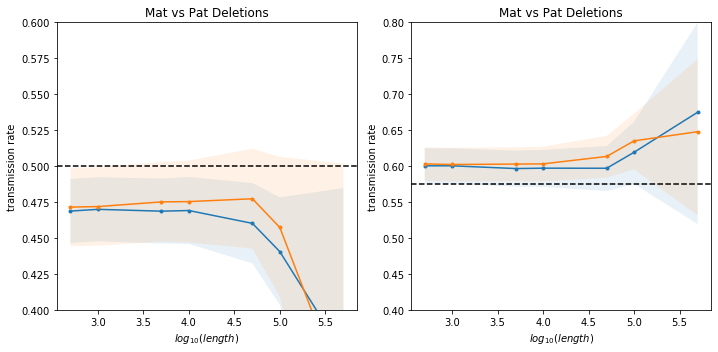

In [165]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
#plt.plot(np.arange(1, 6.5, 0.5), (mat_aff_del_n+mat_unaff_del_n)/(mat_aff_del_n+mat_unaff_del_n+pat_aff_del_n+pat_unaff_del_n), marker='.')
#plt.fill_between(np.arange(1, 6.5, 0.5),
#                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[0] for x, y in zip(mat_aff_del_n+mat_unaff_del_n, pat_aff_del_n+pat_unaff_del_n)],
#                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[1] for x, y in zip(mat_aff_del_n+mat_unaff_del_n, pat_aff_del_n+pat_unaff_del_n)],
#                alpha=0.1)
plt.plot(np.log10(bins[:-1]), mat_aff/(mat_aff+pat_aff), marker='.')
plt.fill_between(np.log10(bins[:-1]),
                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[0] for x, y in zip(mat_aff, pat_aff)],
                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[1] for x, y in zip(mat_aff, pat_aff)],
                alpha=0.1)
plt.plot(np.log10(bins[:-1]), mat_unaff/(mat_unaff+pat_unaff), marker='.')
plt.fill_between(np.log10(bins[:-1]),
                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[0] for x, y in zip(mat_unaff, pat_unaff)],
                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[1] for x, y in zip(mat_unaff, pat_unaff)],
                alpha=0.1)

plt.title('Mat vs Pat Deletions')
plt.xlabel('$log_{10}(length)$')
plt.ylabel('transmission rate')
plt.axhline(0.5, color='black', linestyle='--')
plt.ylim([0.4, 0.6])

plt.subplot(1, 3, 2)
#plt.plot(np.arange(1, 6.5, 0.5), (mat_aff_del_n+mat_unaff_del_n)/(mat_aff_del_n+mat_unaff_del_n+pat_aff_del_n+pat_unaff_del_n), marker='.')
#plt.fill_between(np.arange(1, 6.5, 0.5),
#                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[0] for x, y in zip(mat_aff_del_n+mat_unaff_del_n, pat_aff_del_n+pat_unaff_del_n)],
#                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[1] for x, y in zip(mat_aff_del_n+mat_unaff_del_n, pat_aff_del_n+pat_unaff_del_n)],
#                alpha=0.1)
plt.plot(np.log10(bins[:-1]), mat_aff/(mat_aff+mat_unaff), marker='.')
plt.fill_between(np.log10(bins[:-1]),
                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[0] for x, y in zip(mat_aff, mat_unaff)],
                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[1] for x, y in zip(mat_aff, mat_unaff)],
                alpha=0.1)
plt.plot(np.log10(bins[:-1]), pat_aff/(pat_aff+pat_unaff), marker='.')
plt.fill_between(np.log10(bins[:-1]),
                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[0] for x, y in zip(pat_aff, pat_unaff)],
                 [sm.stats.proportion_confint(x, x+y, alpha=0.05, method='agresti_coull')[1] for x, y in zip(pat_aff, pat_unaff)],
                alpha=0.1)

plt.title('Mat vs Pat Deletions')
plt.xlabel('$log_{10}(length)$')
plt.ylabel('transmission rate')
plt.axhline(np.sum(is_aut)/np.sum(is_aut | is_nt), color='black', linestyle='--')
plt.ylim([0.4, 0.8])

plt.tight_layout()
plt.show()

In [136]:
children_phens = []
in_children_phen = set()

for fam, inds in fam_to_inds.items():
    fam_children = [x for x in inds[2:] if x in individuals]
    if len(fam_children)>0:
        phens = [child_id_to_affected[x] for x in fam_children]
        random.shuffle(phens)
        children_phens.append((fam_children, phens))
        in_children_phen.update(fam_children)
        
print(len(children_phens))

680


In [137]:
assert np.all([x['child'] in in_children_phen and (x['child'] in children) for x in deletions])
assert np.all([x['child'] in in_children_phen and (x['child'] in children) for x in notrans_deletions])

In [138]:
print(len([d for d in deletions if d['is_mat']]))
print(len([d for d in deletions if d['is_pat']]))

86109
87652


In [101]:
# result could be due to family size, so try a permutation test

#bins = np.quantile([x['length'] for x in deletions], np.arange(0, 1.2, 0.2))
bins = [10**x for x in np.arange(2, 6, 1)] + [10**9]
print(bins)
num_permutations = 1000

permute_pvalues = np.ones((len(bins)-1, num_permutations))
mat_permute_pvalues = np.ones((len(bins)-1, num_permutations))
pat_permute_pvalues = np.ones((len(bins)-1, num_permutations))

del_length = np.array([x['length'] for x in deletions])
notrans_del_length = np.array([x['length'] for x in notrans_deletions])

del_is_mat = np.array([x['is_mat'] for x in deletions])
del_is_pat = np.array([x['is_pat'] for x in deletions])
notrans_del_is_mat = np.array([x['is_mat'] for x in notrans_deletions])
notrans_del_is_pat = np.array([x['is_pat'] for x in notrans_deletions])

def calculate_pvalues(aff, min_length, max_length):
    del_is_aff = np.array([(aff[x['child']]=='2') and (x['length']>=min_length) and (x['length']<max_length) for x in deletions])
    del_is_unaff = np.array([(aff[x['child']]=='1') and (x['length']>=min_length) and (x['length']<max_length) and (x['length']>=min_length) for x in deletions])
    notrans_del_is_aff = np.array([(aff[x['child']]=='2') and (x['length']>=min_length) and (x['length']<max_length) for x in notrans_deletions])
    notrans_del_is_unaff = np.array([(aff[x['child']]=='1') and (x['length']>=min_length) and (x['length']<max_length) for x in notrans_deletions])
   
    pvalue = stats.chi2_contingency([[np.sum(del_is_aff), 
                                      np.sum(del_is_unaff)], 
                                     [np.sum(notrans_del_is_aff), 
                                      np.sum(notrans_del_is_unaff)]])[1]
        
    mat_pvalue = stats.chi2_contingency([[np.sum(del_is_mat & del_is_aff), 
                                          np.sum(del_is_mat & del_is_unaff)], 
                                         [np.sum(notrans_del_is_mat & notrans_del_is_aff), 
                                          np.sum(notrans_del_is_mat & notrans_del_is_unaff)]])[1]

    pat_pvalue = stats.chi2_contingency([[np.sum(del_is_pat & del_is_aff), 
                                         np.sum(del_is_pat & del_is_unaff)], 
                                         [np.sum(notrans_del_is_pat & notrans_del_is_aff), 
                                         np.sum(notrans_del_is_pat & notrans_del_is_unaff)]])[1]
    
    return pvalue, mat_pvalue, pat_pvalue
    
for j in range(num_permutations):
    new_child_id_to_affected = dict()
    [random.shuffle(p) for c, p in children_phens]
    for fam_children, phens in children_phens:
        new_child_id_to_affected.update(list(zip(fam_children, phens)))
            
    for bin_index in np.arange(len(bins)-1):
        permute_pvalues[bin_index, j], mat_permute_pvalues[bin_index, j], pat_permute_pvalues[bin_index, j] = calculate_pvalues(new_child_id_to_affected, bins[bin_index], bins[bin_index+1])
        
            
    if j%100==0:
        print(j, end=' ')
    
        

[100, 1000, 10000, 100000, 1000000000]
0 100 200 300 400 500 600 700 800 900 

In [102]:
pvalues = np.ones((len(bins)-1,))
mat_pvalues = np.ones((len(bins)-1,))
pat_pvalues = np.ones((len(bins)-1,))

for bin_index in np.arange(len(bins)-1):
    pvalue, mat_pvalue, pat_pvalue = calculate_pvalues(child_id_to_affected, bins[bin_index], bins[bin_index+1])
    print(pvalue, mat_pvalue, pat_pvalue)

    pvalues[bin_index] = np.sum(permute_pvalues[bin_index, :]<=pvalue)/np.sum(~np.isnan(permute_pvalues[bin_index, :]))
    mat_pvalues[bin_index] = np.sum(mat_permute_pvalues[bin_index, :]<=mat_pvalue)/np.sum(~np.isnan(mat_permute_pvalues[bin_index, :]))
    pat_pvalues[bin_index] = np.sum(pat_permute_pvalues[bin_index, :]<=pat_pvalue)/np.sum(~np.isnan(pat_permute_pvalues[bin_index, :]))
        
        
print(bins)
for i in range(len(bins)-1):
    min_length, max_length = bins[i], bins[i+1]
    print(min_length, max_length,
          np.sum([(x['length']>=min_length) and (x['length']<max_length) for x in deletions]),
          np.sum([(x['length']>=min_length) and (x['length']<max_length) for x in notrans_deletions]))
    print(np.sum([(x['length']>=min_length) and (x['length']<max_length) and x['is_mat'] for x in deletions]),
          np.sum([(x['length']>=min_length) and (x['length']<max_length) and x['is_mat'] for x in notrans_deletions]))
    print(np.sum([(x['length']>=min_length) and (x['length']<max_length) and x['is_pat'] for x in deletions]),
          np.sum([(x['length']>=min_length) and (x['length']<max_length) and x['is_pat'] for x in notrans_deletions]))
print(pvalues)
print(mat_pvalues)
print(pat_pvalues)

0.159145026451316 0.4409297262851446 0.22686550012964712
0.052298006179861536 0.42474582918999626 0.05209784940522712
0.0027047257841983294 0.07902175575129616 3.606345762617393e-10
0.007769802839089767 2.9216068614833335e-11 0.0011836988833302628
[100, 1000, 10000, 100000, 1000000000]
100 1000 65259 23133
32852 11446
32407 11687
1000 10000 227138 89130
113424 44760
113714 44370
10000 100000 74524 34148
38093 18501
36431 15647
100000 1000000000 7281 3713
3697 2063
3584 1650
[0.413 0.536 0.857 0.825]
[0.737 0.81  0.999 0.621]
[0.572 0.152 0.104 0.316]


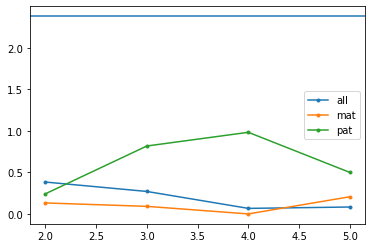

In [103]:
plt.plot(np.log10(bins[:-1]), -np.log10(np.clip(pvalues, 1/num_permutations, 1)), marker='.', label='all')
plt.plot(np.log10(bins[:-1]), -np.log10(np.clip(mat_pvalues, 1/num_permutations, 1)), marker='.', label='mat')
plt.plot(np.log10(bins[:-1]), -np.log10(np.clip(pat_pvalues, 1/num_permutations, 1)), marker='.', label='pat')
plt.legend()
plt.axhline(-np.log10(0.05/len(pvalues)/3))
plt.show()

# Long Deletions

In [760]:
has_long_deletion = np.zeros((len(children),), dtype=bool)
has_long_deletion_mat = np.zeros((len(children),), dtype=bool)
has_long_deletion_pat = np.zeros((len(children),), dtype=bool)

has_deletion = np.zeros((len(children),), dtype=bool)
for d in deletions:
    if d['length']>500000:
        has_long_deletion[child_to_index[d['child']]] = True
        if d['is_mat']:
            has_long_deletion_mat[child_to_index[d['child']]] = True
        if d['is_pat']:
            has_long_deletion_pat[child_to_index[d['child']]] = True
    has_deletion[child_to_index[d['child']]] = True

In [761]:
c = [[np.sum(is_aut & has_long_deletion), np.sum(is_nt & has_long_deletion)],
    [np.sum(is_aut & ~has_long_deletion), np.sum(is_nt & ~has_long_deletion)]]
print(c[0][0]/(c[0][0]+c[1][0]), c[0][1]/(c[0][1]+c[1][1]))
print(stats.chi2_contingency(c))

c = [[np.sum(is_aut & has_long_deletion_mat), np.sum(is_aut & has_long_deletion_pat)],
    [np.sum(is_aut & ~has_long_deletion_mat), np.sum(is_aut & ~has_long_deletion_pat)]]
print(c[0][0]/(c[0][0]+c[1][0]), c[0][1]/(c[0][1]+c[1][1]))
print(stats.chi2_contingency(c))

c = [[np.sum(is_nt & has_long_deletion_mat), np.sum(is_nt & has_long_deletion_pat)],
    [np.sum(is_nt & ~has_long_deletion_mat), np.sum(is_nt & ~has_long_deletion_pat)]]
print(c[0][0]/(c[0][0]+c[1][0]), c[0][1]/(c[0][1]+c[1][1]))
print(stats.chi2_contingency(c))

0.21338028169014084 0.19291338582677164
(0.4272465611214372, 0.5133431208353489, 1, array([[ 298.59020311,   53.40979689],
       [1121.40979689,  200.59020311]]))
0.11056338028169015 0.11830985915492957
(0.3474537391038385, 0.5555580577275773, 1, array([[ 162.5,  162.5],
       [1257.5, 1257.5]]))
0.14173228346456693 0.09055118110236221
(2.7613906609792003, 0.0965642633319517, 1, array([[ 29.5,  29.5],
       [224.5, 224.5]]))


In [762]:
c = [[np.sum(is_aut & has_deletion), np.sum(is_nt & has_deletion)],
    [np.sum(is_aut & ~has_deletion), np.sum(is_nt & ~has_deletion)]]
print(c[0][0]/(c[0][0]+c[1][0]), c[0][1]/(c[0][1]+c[1][1]))
print(stats.chi2_contingency(c))

0.9992957746478873 0.9960629921259843
(0.1502307791953848, 0.6983149149521053, 1, array([[1.41830346e+03, 2.53696535e+02],
       [1.69653524e+00, 3.03464755e-01]]))


# Rare deletions

In [504]:
print(len(full_deletions))

2427


In [523]:
private_deletions = []

chrom_to_interval_starts, chrom_to_interval_ends = defaultdict(list), defaultdict(list)

for d in full_deletions:
    chrom_to_interval_starts[d['chrom']].append(d['start_pos'])
    chrom_to_interval_ends[d['chrom']].append(d['end_pos'])
     
for chrom in [str(x) for x in range(1, 23)]:
    chrom_to_interval_starts[chrom] = np.array(chrom_to_interval_starts[chrom])
    chrom_to_interval_ends[chrom] = np.array(chrom_to_interval_ends[chrom])
         
excluded_deletions = set()
for i, d in enumerate(full_deletions):
    starts, ends = chrom_to_interval_starts[d['chrom']], chrom_to_interval_ends[d['chrom']]
    overlaps = np.clip(np.minimum(d['end_pos'], ends) - np.maximum(d['start_pos'], starts), 0, None)
    if np.sum((overlaps>0.5*d['length']) & (overlaps>0.5*(ends-starts))) > 1:
        excluded_deletions.add(i)
print('excluded deletions', len(excluded_deletions)) 
rare_full_deletions = [d for i, d in enumerate(full_deletions) if i not in excluded_deletions]
print('remaining deletions', len(rare_full_deletions))

excluded deletions 1321
remaining deletions 1106


In [524]:
rare_deletions = []
rare_notrans_deletions = []

for d in rare_full_deletions:
    if d['is_inherited'] and d['family_size']>=4 and fam_to_size[d['family']] == d['family_size']:
        for child in d['trans']:
            rare_deletions.append({
                                'family': d['family'],
                                'child': child,
                                'chrom': d['chrom'],
                                'start_pos': d['start_pos'],
                                'end_pos': d['end_pos'],
                                'length': d['length'],
                                'opt_start_pos': d['opt_start_pos'],
                                'opt_end_pos': d['opt_end_pos'],
                                'is_mat': d['is_mat'],
                                'is_pat': d['is_pat'],
                                'mother': d['mother'],
                                'father': d['father'],
                                'is_inherited': d['is_inherited'],
                                'is_denovo': d['is_denovo']
                        })
        for child in d['notrans']:
            rare_notrans_deletions.append({
                                'family': d['family'],
                                'child': child,
                                'chrom': d['chrom'],
                                'start_pos': d['start_pos'],
                                'end_pos': d['end_pos'],
                                'length': d['length'],
                                'opt_start_pos': d['opt_start_pos'],
                                'opt_end_pos': d['opt_end_pos'],
                                'is_mat': d['is_mat'],
                                'is_pat': d['is_pat'],
                                'mother': d['mother'],
                                'father': d['father'],
                                'is_inherited': d['is_inherited'],
                                'is_denovo': d['is_denovo']
                        })

In [537]:
# result could be due to family size, so try a permutation test

#bins = np.quantile([x['length'] for x in deletions], np.arange(0, 1.2, 0.2))
bins = [10**x for x in np.arange(2, 6, 1)] + [10**9]
print(bins)
num_permutations = 10000

permute_pvalues = np.ones((len(bins)-1, num_permutations))
mat_permute_pvalues = np.ones((len(bins)-1, num_permutations))
pat_permute_pvalues = np.ones((len(bins)-1, num_permutations))

del_length = np.array([x['length'] for x in rare_deletions])
notrans_del_length = np.array([x['length'] for x in rare_notrans_deletions])

del_is_mat = np.array([x['is_mat'] for x in rare_deletions])
del_is_pat = np.array([x['is_pat'] for x in rare_deletions])
notrans_del_is_mat = np.array([x['is_mat'] for x in rare_notrans_deletions])
notrans_del_is_pat = np.array([x['is_pat'] for x in rare_notrans_deletions])

def calculate_pvalues(aff, min_length, max_length):
    del_is_aff = np.array([(aff[x['child']]=='2') and (x['length']>=min_length) and (x['length']<max_length) for x in rare_deletions])
    del_is_unaff = np.array([(aff[x['child']]=='1') and (x['length']>=min_length) and (x['length']<max_length) and (x['length']>=min_length) for x in rare_deletions])
    notrans_del_is_aff = np.array([(aff[x['child']]=='2') and (x['length']>=min_length) and (x['length']<max_length) for x in rare_notrans_deletions])
    notrans_del_is_unaff = np.array([(aff[x['child']]=='1') and (x['length']>=min_length) and (x['length']<max_length) for x in rare_notrans_deletions])
   
    pvalue = stats.chi2_contingency([[np.sum(del_is_aff), 
                                      np.sum(del_is_unaff)], 
                                     [np.sum(notrans_del_is_aff), 
                                      np.sum(notrans_del_is_unaff)]])[1]
        
    mat_pvalue = stats.chi2_contingency([[np.sum(del_is_mat & del_is_aff), 
                                          np.sum(del_is_mat & del_is_unaff)], 
                                         [np.sum(notrans_del_is_mat & notrans_del_is_aff), 
                                          np.sum(notrans_del_is_mat & notrans_del_is_unaff)]])[1]

    pat_pvalue = stats.chi2_contingency([[np.sum(del_is_pat & del_is_aff), 
                                         np.sum(del_is_pat & del_is_unaff)], 
                                         [np.sum(notrans_del_is_pat & notrans_del_is_aff), 
                                         np.sum(notrans_del_is_pat & notrans_del_is_unaff)]])[1]
    
    return pvalue, mat_pvalue, pat_pvalue
    
for j in range(num_permutations):
    new_child_id_to_affected = dict()
    [random.shuffle(p) for c, p in children_phens]
    for fam_children, phens in children_phens:
        new_child_id_to_affected.update(list(zip(fam_children, phens)))
            
    for bin_index in np.arange(len(bins)-1):
        permute_pvalues[bin_index, j], mat_permute_pvalues[bin_index, j], pat_permute_pvalues[bin_index, j] = calculate_pvalues(new_child_id_to_affected, bins[bin_index], bins[bin_index+1])
        
            
    if j%100==0:
        print(j, end=' ')
    
        

[100, 1000, 10000, 100000, 1000000000]
0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900 

In [538]:
rare_pvalues = np.ones((len(bins)-1,))
rare_mat_pvalues = np.ones((len(bins)-1,))
rare_pat_pvalues = np.ones((len(bins)-1,))

for bin_index in np.arange(len(bins)-1):
    pvalue, mat_pvalue, pat_pvalue = calculate_pvalues(child_id_to_affected, bins[bin_index], bins[bin_index+1])
    print(pvalue, mat_pvalue, pat_pvalue)

    rare_pvalues[bin_index] = np.sum(permute_pvalues[bin_index, :]<=pvalue)/np.sum(~np.isnan(permute_pvalues[bin_index, :]))
    rare_mat_pvalues[bin_index] = np.sum(mat_permute_pvalues[bin_index, :]<=mat_pvalue)/np.sum(~np.isnan(mat_permute_pvalues[bin_index, :]))
    rare_pat_pvalues[bin_index] = np.sum(pat_permute_pvalues[bin_index, :]<=pat_pvalue)/np.sum(~np.isnan(pat_permute_pvalues[bin_index, :]))
        
        
print(bins)
for i in range(len(bins)-1):
    min_length, max_length = bins[i], bins[i+1]
    print(min_length, max_length,
          np.sum([(x['length']>=min_length) and (x['length']<max_length) for x in rare_deletions]),
          np.sum([(x['length']>=min_length) and (x['length']<max_length) for x in rare_notrans_deletions]))
    print(np.sum([(x['length']>=min_length) and (x['length']<max_length) and x['is_mat'] for x in rare_deletions]),
          np.sum([(x['length']>=min_length) and (x['length']<max_length) and x['is_mat'] for x in rare_notrans_deletions]))
    print(np.sum([(x['length']>=min_length) and (x['length']<max_length) and x['is_pat'] for x in rare_deletions]),
          np.sum([(x['length']>=min_length) and (x['length']<max_length) and x['is_pat'] for x in rare_notrans_deletions]))
print(rare_pvalues)
print(rare_mat_pvalues)
print(rare_pat_pvalues)

0.21042229121880726 nan 0.21042229121880726
0.4458643717185201 0.9849565437768274 0.2172145379518541
0.3650297564173761 0.758615056132943 0.10683052735268818
2.545853470336981e-10 0.009545137187730306 3.0434990200584154e-09
[100, 1000, 10000, 100000, 1000000000]
100 1000 12 2
0 0
12 2
1000 10000 128 40
54 14
74 26
10000 100000 822 386
375 181
447 205
100000 1000000000 601 313
241 123
360 190
[0.1637 0.4123 0.4166 0.    ]
[   nan 1.     0.7356 0.0386]
[0.1637 0.2592 0.1784 0.0008]


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in less_equal
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in long_scalars


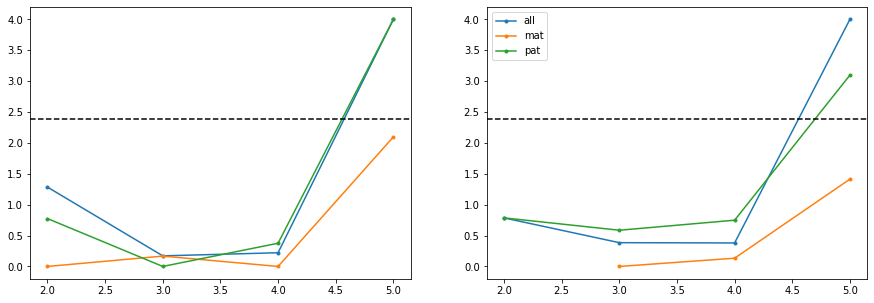

In [539]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(np.log10(bins[:-1]), -np.log10(np.clip(pvalues, 1/num_permutations, 1)), marker='.', label='all')
plt.plot(np.log10(bins[:-1]), -np.log10(np.clip(mat_pvalues, 1/num_permutations, 1)), marker='.', label='mat')
plt.plot(np.log10(bins[:-1]), -np.log10(np.clip(pat_pvalues, 1/num_permutations, 1)), marker='.', label='pat')
plt.axhline(-np.log10(0.05/len(pvalues)/3), color='black', linestyle='--')


plt.subplot(1, 2, 2)
plt.plot(np.log10(bins[:-1]), -np.log10(np.clip(rare_pvalues, 1/num_permutations, 1)), marker='.', label='all')
plt.plot(np.log10(bins[:-1]), -np.log10(np.clip(rare_mat_pvalues, 1/num_permutations, 1)), marker='.', label='mat')
plt.plot(np.log10(bins[:-1]), -np.log10(np.clip(rare_pat_pvalues, 1/num_permutations, 1)), marker='.', label='pat')
plt.legend()
plt.axhline(-np.log10(0.05/len(pvalues)/3), color='black', linestyle='--')
plt.show()

In [540]:
print(len(rare_deletions), len(deletions))

1563 3508


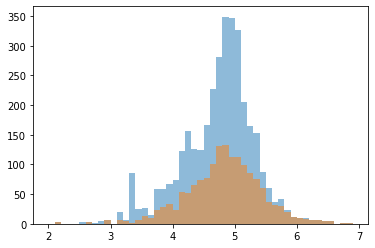

In [541]:
plt.hist([np.log10(d['length']) for d in deletions], alpha=0.5, bins=np.arange(2, 7, 0.1))
plt.hist([np.log10(d['length']) for d in rare_deletions], alpha=0.5, bins=np.arange(2, 7, 0.1))
plt.show()

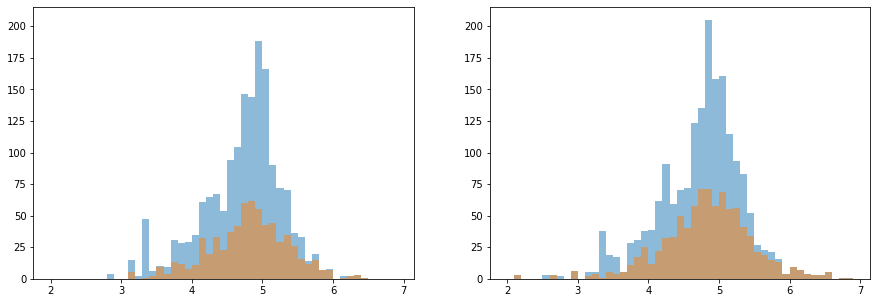

In [548]:
plt.figure(figsize=(15, 5))

ax = plt.subplot(1, 2, 1)
plt.hist([np.log10(d['length']) for d in deletions if d['is_mat']], alpha=0.5, bins=np.arange(2, 7, 0.1))
plt.hist([np.log10(d['length']) for d in rare_deletions if d['is_mat']], alpha=0.5, bins=np.arange(2, 7, 0.1))

plt.subplot(1, 2, 2, sharey=ax)
plt.hist([np.log10(d['length']) for d in deletions if d['is_pat']], alpha=0.5, bins=np.arange(2, 7, 0.1))
plt.hist([np.log10(d['length']) for d in rare_deletions if d['is_pat']], alpha=0.5, bins=np.arange(2, 7, 0.1))
plt.show()

In [562]:
print(len([d for d in rare_deletions if d['is_mat']]), 
      len([d for d in rare_deletions if d['is_pat']]))
print(len([d for d in rare_notrans_deletions if d['is_mat']]), 
      len([d for d in rare_notrans_deletions if d['is_pat']]))
print()

print(len([d for d in rare_deletions if d['is_mat']])/len(rare_deletions))
print(len([d for d in deletions if d['is_mat']])/len(deletions))

print()
print(len([d for d in rare_deletions if d['is_mat'] and child_id_to_affected[d['child']]=='2'])/len([d for d in rare_deletions if child_id_to_affected[d['child']]=='2']))
print(len([d for d in deletions if d['is_mat'] and child_id_to_affected[d['child']]=='2'])/len([d for d in deletions if child_id_to_affected[d['child']]=='2']))


print(len([d for d in rare_deletions if d['is_mat'] and child_id_to_affected[d['child']]=='1'])/len([d for d in rare_deletions if child_id_to_affected[d['child']]=='1']))
print(len([d for d in deletions if d['is_mat'] and child_id_to_affected[d['child']]=='1'])/len([d for d in deletions if child_id_to_affected[d['child']]=='1']))



670 893
318 423

0.4286628278950736
0.4740592930444698

0.42573221757322177
0.4738084001887683
0.4332784184514003
0.4744420446364291


In [563]:
print(stats.chi2_contingency([[len([d for d in rare_deletions if d['is_mat']]),
                              len([d for d in rare_deletions if d['is_pat']])],
                             [len([d for d in deletions if d['is_mat']])-len([d for d in rare_deletions if d['is_mat']]),
                              len([d for d in deletions if d['is_pat']])-len([d for d in rare_deletions if d['is_pat']])]]))

print(stats.chi2_contingency([[len([d for d in deletions if d['is_mat'] and child_id_to_affected[d['child']]=='2' and d['length']>100000]),
                              len([d for d in deletions if d['is_pat'] and child_id_to_affected[d['child']]=='2' and d['length']>100000])],
                             [len([d for d in deletions if d['is_mat'] and child_id_to_affected[d['child']]=='1' and d['length']>100000]),
                              len([d for d in deletions if d['is_pat'] and child_id_to_affected[d['child']]=='1' and d['length']>100000])]]))

print(stats.chi2_contingency([[len([d for d in rare_deletions if d['is_mat'] and child_id_to_affected[d['child']]=='2' and d['length']>100000]),
                              len([d for d in rare_deletions if d['is_pat'] and child_id_to_affected[d['child']]=='2' and d['length']>100000])],
                             [len([d for d in rare_deletions if d['is_mat'] and child_id_to_affected[d['child']]=='1' and d['length']>100000]),
                              len([d for d in rare_deletions if d['is_pat'] and child_id_to_affected[d['child']]=='1' and d['length']>100000])]]))


print(stats.chi2_contingency([[len([d for d in rare_deletions if d['is_mat'] and child_id_to_affected[d['child']]=='2']),
                              len([d for d in rare_deletions if d['is_pat'] and child_id_to_affected[d['child']]=='2'])],
                             [len([d for d in rare_deletions if d['is_mat'] and child_id_to_affected[d['child']]=='1']),
                              len([d for d in rare_deletions if d['is_pat'] and child_id_to_affected[d['child']]=='1'])]]))



(22.973712549882684, 1.6423183408588564e-06, 1, array([[ 740.95467503,  822.04532497],
       [ 922.04532497, 1022.95467503]]))
(0.11188719938730143, 0.7380057312863713, 1, array([[330.22916667, 395.77083333],
       [193.77083333, 232.22916667]]))
(0.0002310267169026245, 0.9878729702581155, 1, array([[155.58735441, 232.41264559],
       [ 85.41264559, 127.58735441]]))
(0.058262315183217436, 0.8092638055523651, 1, array([[409.80166347, 546.19833653],
       [260.19833653, 346.80166347]]))


# Create matrix for GLRM 

In [189]:
print(len(children))

6721


In [255]:
del_matrices = []
del_matrices_ismat = []
del_matrices_ispat = []

for chrom in [str(x) for x in range(1, 23)]:
    chrom_deletions = [d for d in deletions if d['chrom']==chrom]
    chrom_notrans_deletions = [d for d in notrans_deletions if d['chrom']==chrom]
    
    endpoints = [d['start_pos'] for d in chrom_deletions] 
    endpoints += [d['start_pos']-1 for d in chrom_deletions]
    endpoints += [d['end_pos'] for d in chrom_deletions]
    endpoints += [d['end_pos']-1 for d in chrom_deletions]
    endpoints = sorted(set(endpoints))
    endpoint_to_index = dict([(x, i) for i, x in enumerate(endpoints)])
    
    del_matrix = np.zeros((len(children), len(endpoints)), dtype=int)
    for d in chrom_deletions:
        del_matrix[child_to_index[d['child']], endpoint_to_index[d['start_pos']]:endpoint_to_index[d['end_pos']]] = 1
    for d in chrom_notrans_deletions:
        del_matrix[child_to_index[d['child']], endpoint_to_index[d['start_pos']]:endpoint_to_index[d['end_pos']]] = -1
    del_matrices.append(del_matrix)
    
    del_matrix_ismat = np.zeros((len(children), len(endpoints)), dtype=int)
    for d in chrom_deletions:
        if d['is_mat']:
            del_matrix_ismat[child_to_index[d['child']], endpoint_to_index[d['start_pos']]:endpoint_to_index[d['end_pos']]] = 1
    for d in chrom_notrans_deletions:
        if d['is_mat']:
            del_matrix_ismat[child_to_index[d['child']], endpoint_to_index[d['start_pos']]:endpoint_to_index[d['end_pos']]] = -1
    del_matrices_ismat.append(del_matrix_ismat)
    
    del_matrix_ispat = np.zeros((len(children), len(endpoints)), dtype=int)
    for d in chrom_deletions:
        if d['is_pat']:
            del_matrix_ispat[child_to_index[d['child']], endpoint_to_index[d['start_pos']]:endpoint_to_index[d['end_pos']]] = 1
    for d in chrom_notrans_deletions:
        if d['is_pat']:
            del_matrix_ispat[child_to_index[d['child']], endpoint_to_index[d['start_pos']]:endpoint_to_index[d['end_pos']]] = -1
    del_matrices_ispat.append(del_matrix_ispat)
    
del_matrix = np.hstack(del_matrices)
del_matrix_ismat = np.hstack(del_matrices_ismat)
del_matrix_ispat = np.hstack(del_matrices_ispat)
print(del_matrix.shape)

(6721, 6016)


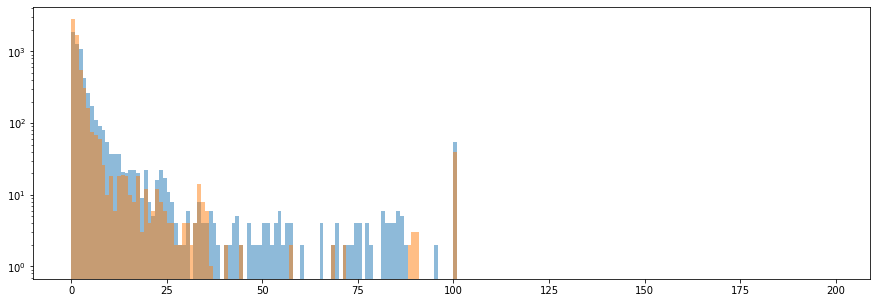

In [256]:
plt.figure(figsize=(15, 5))
plt.hist(np.clip(np.sum((del_matrix==1), axis=0), None, 100), log=True, bins=np.arange(0, 200, 1), alpha=0.5)
plt.hist(np.clip(np.sum((del_matrix==-1), axis=0), None, 100), log=True, bins=np.arange(0, 200, 1), alpha=0.5)
plt.show()

# Predict ASD

In [257]:
X = np.unique(del_matrix, axis=1)
X = X[:, np.sum(X==1, axis=0)>5]
print(X.shape)

X_ismat = np.unique(del_matrix_ismat, axis=1)
X_ismat = X_ismat[:, np.sum(X_ismat==1, axis=0)>5]
print(X_ismat.shape)

X_ispat = np.unique(del_matrix_ispat, axis=1)
X_ispat = X_ispat[:, np.sum(X_ispat==1, axis=0)>5]
print(X_ispat.shape)

(6721, 457)
(6721, 179)
(6721, 201)


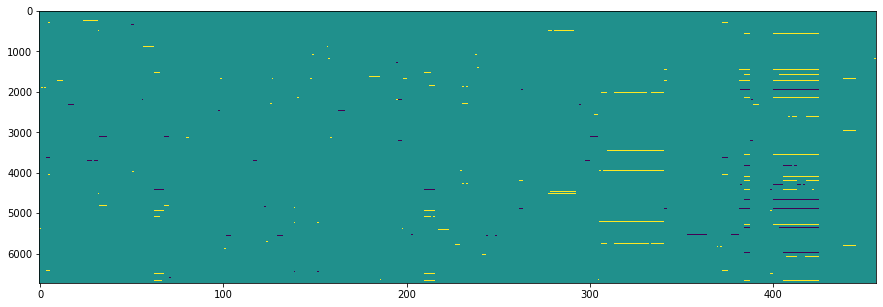

In [258]:
plt.figure(figsize=(15, 5))
plt.imshow(X, aspect='auto')
plt.show()

In [259]:
y = np.array([child_id_to_affected[x]=='2' for x in children])

In [264]:
# try a permutation test

num_permutations = 1000

permute_pvalues = np.ones((X.shape[1], num_permutations))
permute_pvalues_mat = np.ones((X_ismat.shape[1], num_permutations))
permute_pvalues_pat = np.ones((X_ispat.shape[1], num_permutations))

def calculate_pvalues(y):
    c = np.array([[np.sum(X[y, :]==1, axis=0), 
                                      np.sum(X[~y, :]==1, axis=0)], 
                                     [np.sum(X[y, :]==-1, axis=0), 
                                      np.sum(X[~y, :]==-1, axis=0)]])
    pvalues = np.ones((X.shape[1],))
    for i in range(X.shape[1]):
        try:
            pvalues[i] = stats.chi2_contingency(c[:, :, i])[1]
        except:
            pass
        
    c = np.array([[np.sum(X[y, :]==1, axis=0), 
                                      np.sum(X_ismat[~y, :]==1, axis=0)], 
                                     [np.sum(X_ismat[y, :]==-1, axis=0), 
                                      np.sum(X_ismat[~y, :]==-1, axis=0)]])
    mat_pvalues = np.ones((X_ismat.shape[1],))
    for i in range(X_ismat.shape[1]):
        try:
            mat_pvalues[i] = stats.chi2_contingency(c[:, :, i])[1]
        except:
            pass
        
    c = np.array([[np.sum(X_ispat[y, :]==1, axis=0), 
                                      np.sum(X_ispat[~y, :]==1, axis=0)], 
                                     [np.sum(X_ispat[y, :]==-1, axis=0), 
                                      np.sum(X_ispat[~y, :]==-1, axis=0)]])
    
    pat_pvalues = np.ones((X_ispat.shape[1],))
    for i in range(X_ispat.shape[1]):
        try:
            pat_pvalues[i] = stats.chi2_contingency(c[:, :, i])[1]
        except:
            pass
    
    return pvalues, mat_pvalues, pat_pvalues
    
permute_y = np.zeros((len(children),), dtype=bool)
for j in range(num_permutations):
    [random.shuffle(p) for c, p in children_phens]
    for fam_children, phens in children_phens:
        for child, new_phen in zip(fam_children, phens):
            permute_y[child_to_index[child]] = (new_phen=='2')
            
    permute_pvalues[:, j], permute_pvalues_mat[:, j], permute_pvalues_pat[:, j] = calculate_pvalues(permute_y)
        
            
    if j%100==0:
        print(j, end=' ')
    
        

0 100 200 300 400 500 600 700 800 900 

In [265]:
unadj_pvalues, unadj_pvalues_mat, unadj_pvalues_pat = calculate_pvalues(y)
indices = np.argsort(unadj_pvalues)
indices_mat = np.argsort(unadj_pvalues_mat)
indices_pat = np.argsort(unadj_pvalues_pat)

pi = np.ones((X.shape[1], 3))

min_pvalues = np.min(permute_pvalues, axis=0)
min_pvalues_mat = np.min(permute_pvalues_mat, axis=0)
min_pvalues_pat = np.min(permute_pvalues_pat, axis=0)
pi[0, 0] = np.sum(min_pvalues <= unadj_pvalues[indices[0]])/num_permutations
pi[0, 1] = np.sum(min_pvalues_mat <= unadj_pvalues_mat[indices_mat[0]])/num_permutations
pi[0, 2] = np.sum(min_pvalues_pat <= unadj_pvalues_pat[indices_pat[0]])/num_permutations
for i in range(1, 20):
    min_pvalues = np.min(permute_pvalues[indices>=i, :], axis=0)
    min_pvalues_mat = np.min(permute_pvalues_mat[indices_mat>=i, :], axis=0)
    min_pvalues_pat = np.min(permute_pvalues_pat[indices_pat>=i, :], axis=0)
    pi[i, 0] = max(pi[i-1, 0], np.sum(min_pvalues <= unadj_pvalues[indices[i]])/num_permutations)
    pi[i, 1] = max(pi[i-1, 1], np.sum(min_pvalues_mat <= unadj_pvalues_mat[indices_mat[i]])/num_permutations)
    pi[i, 2] = max(pi[i-1, 2], np.sum(min_pvalues_pat <= unadj_pvalues_pat[indices_pat[i]])/num_permutations)
    
    if i%10==0:
        print(i, '/', 20)


10 / 20


In [263]:
print(pi[:20])

[[0.402 1.    0.378]
 [0.402 1.    0.423]
 [0.55  1.    0.443]
 [0.628 1.    0.517]
 [0.795 1.    0.539]
 [0.831 1.    0.571]
 [0.832 1.    0.594]
 [0.841 1.    0.609]
 [0.86  1.    0.678]
 [0.875 1.    0.693]
 [0.881 1.    0.704]
 [0.892 1.    0.861]
 [0.906 1.    0.904]
 [0.922 1.    0.929]
 [0.937 1.    0.929]
 [0.937 1.    0.929]
 [0.937 1.    0.935]
 [0.968 1.    0.949]
 [0.986 1.    0.956]
 [0.997 1.    0.963]]


In [326]:
pvalues = np.ones((X.shape[1],))

perm_pvalues = np.ones((X.shape[1],))
for i in range(X.shape[1]):
    perm_pvalues[i] = np.sum(permute_pvalues[i, :]<=unadj_pvalues[i])/num_permutations
    

    
plt.hist(-np.log10(perm_pvalues), alpha=0.5, bins=np.arange(0.1, 3, 0.1))
#plt.hist(-np.log10(unadj_pvalues), alpha=0.5, bins=np.arange(0, 3, 0.1))
plt.axvline(-np.log10(0.05), color='black', linestyle='--')
plt.show()

IndexError: index 4 is out of bounds for axis 0 with size 4

# try GLRM using G + P

In [18]:
phen_data = np.zeros((len(children), 40))
with open('../phenotypes/spark/scq.csv', 'r') as f:
    header = next(f).split(',')
    for line in f:
        pieces = line.strip().split(',')
        if pieces[0] in child_to_index:
            child_index = child_to_index[pieces[0]]
            phen_data[child_index, :] = [1 if x=='1' else -1 if x=='0' else 0 for x in pieces[11:51]]

In [19]:
phen_data[phen_data==0] = np.nan

In [20]:
from pyglrm import glrm, observations
g = glrm(n_components=2)
g.fit_impute(A)
g.get_hyperprams()

RuntimeError: PyJulia does not support Julia < 0.7 anymore